#### using transfer learning for the segementation job

In [1]:
import torch

print(torch.cuda.is_available())

True


/home/li52/.conda/envs/LM/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import tensorflow as tf

print(tf.__version__)

2022-05-16 15:11:40.373011: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


2.4.1


In [3]:
print(tf.__file__)

/home/li52/.conda/envs/LM/lib/python3.7/site-packages/tensorflow/__init__.py


In [4]:
# check the status of GPU
from tensorflow.python.client import device_lib

local_device_protos = device_lib.list_local_devices()

[print(x) for x in local_device_protos if x.device_type == 'GPU']


2022-05-16 15:11:46.567860: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-16 15:11:46.568162: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-05-16 15:11:46.568648: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-05-16 15:11:46.568669: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-05-16 15:11:46.568695: I tensorflow/stream_executor/platform/default/dso

[]

define the neptune for documenting

In [ ]:
# define if the documenting process should go on

DOCUMENT = True
TRAIN = 50  # training epochs num


In [ ]:
# neptune document

import neptune.new as neptune
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

if DOCUMENT:

    run = neptune.init(
        project="leeleeroy/LM-2D-Unet",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
        name = "UNet2D_64_vgg16",
    ) # necessary credentials, the name could be used to reproduce the results 

    # for callbacks in training



    neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')  # neptune for the training process
    
    # neptune document the hyper param.

    PARAMS = {
              "optimizer": {"learning_rate": 0.001, "beta_1":0.9,"optimizer": "Adam"},
              'epochs': TRAIN,
              'batch_size':8}

    # log hyper-parameters
    run['hyper-parameters'] = PARAMS
    run["sys/tags"].add(["transfer", "vgg16", "val", "test", "epochs:50"])


In [1]:
# data loading 

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os
import pandas as pd
import random

#### Load data in

In [2]:
PATH = '/bigdata/casus/MLID/RuiLi/Data/LM/zebrafish_partial/'

Mask = np.load(PATH + 'fMax.npy')
IMG = np.load(PATH + 'rawIMG.npy')

Mask = Mask.reshape(-1, 1040, 1392)  # flatten into images 
IMG = IMG.reshape(-1, 1040, 1392)

print('Mask shape: ', Mask.shape)
print('Image shape: ', IMG.shape)

Mask shape:  (380, 1040, 1392)
Image shape:  (380, 1040, 1392)


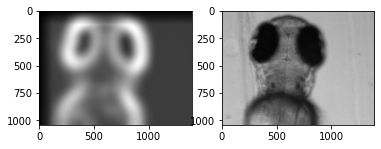

In [3]:
# sanity check

tMask = Mask[0,...]
tIMG = IMG[0,...]

plt.subplot(1,2,1)
plt.imshow(tMask, cmap='gray')
plt.subplot(1,2,2)
plt.imshow(tIMG, cmap='gray')
plt.show()

In [4]:
# patchify the images

def rawPatch(imageStack,patchPara):
    all_img_patches = []

    for img in range(imageStack.shape[0]):
        large_image = imageStack[img]

        patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])  # no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1

                all_img_patches.append(single_patch_img)
    
    return all_img_patches, patches_img.shape

In [5]:
# due to the huge data amount, use part of the images for the training 
smallIMG = IMG[:50,...]
smallMask = Mask[:50,...]  

In [36]:
print('img:',smallIMG.shape, smallIMG.dtype)
print('mask:',smallMask.shape, smallMask.dtype)

print(np.max(smallIMG), np.min(smallIMG))
print(np.max(smallMask), np.min(smallMask))

img: (50, 1040, 1392) uint8
mask: (50, 1040, 1392) uint8
95 0
219 0


In [6]:
# preporcessing the data

from patchify import patchify, unpatchify


# train dataset
THRESHOLD = 0.5
patchPara = {'x': 256, 'y': 256, 'step':256}

X_patches, _ =  rawPatch(smallIMG, patchPara); X_patches = np.stack((X_patches,)*3, axis=-1)
Y_masks, _ = rawPatch(smallMask, patchPara); Y_masks = np.expand_dims(Y_masks, -1)


In [29]:
print('patches shape:',X_patches.shape, X_patches.dtype)
print('mask shape:',Y_masks.shape, Y_masks.dtype)

patches shape: (1000, 256, 256, 3) float32
mask shape: (1000, 256, 256, 1) float32


In [34]:
print(np.max(Y_masks[0,...]), np.min(Y_masks[0,...]))
print(np.max(X_patches[0,...]), np.min(X_patches[0,...]))

0.27450982 0.0
0.1764706 0.078431375


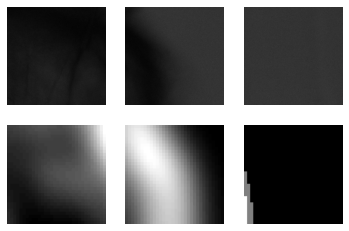

In [8]:
#  sanity check for the mask and images

IMG_test = X_patches
GT_test = Y_masks

startNum = 37
n_samples = 3

for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(IMG_test[int(i+startNum)], cmap='gray')
    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(GT_test[int(i+startNum)], cmap='gray')    
plt.show()


#### prepare the models

In [9]:
# usinng pre-trained weight

import tensorflow
import tensorflow.keras

import segmentation_models as sm

# from keras_applications.resnet import ResNetV2

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

2022-05-13 00:00:54.843845: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


Segmentation Models: using `tf.keras` framework.


In [11]:
# preprocessing the data

# preprocess input
images = X_patches; masks = Y_masks;
images = preprocess_input(images)
# print(images1.shape)  # come with packed toolset

from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(images, masks, test_size = 0.25, random_state = 42)
print('training data:', X_train.shape, Y_train.shape)


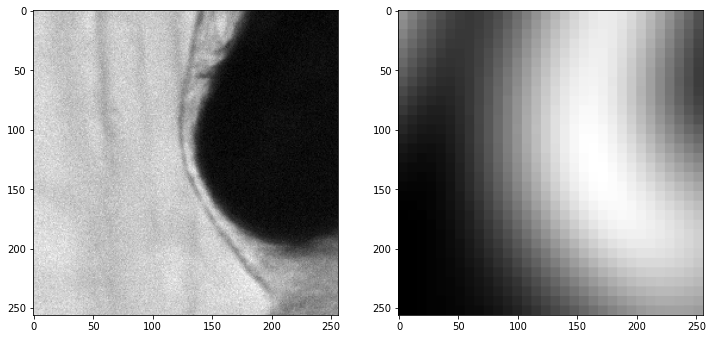

In [18]:
#Sanity check for training dataset. view few mages

import random
import numpy as np
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_train[image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(Y_train[image_number], (256, 256)), cmap='gray')
plt.show()

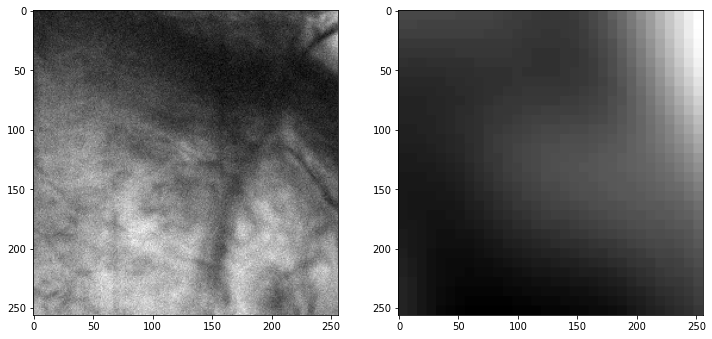

In [19]:
#Sanity check for testing dataset, view few mages

image_number = random.randint(0, len(X_test))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(X_test[image_number, :,:, 0], cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(Y_test[image_number], (256, 256)), cmap='gray')
plt.show()

In [37]:
# data generator

seed=24
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# add data augmentaton strategy
img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     zoom_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='reflect',)
                     #preprocessing_function = lambda x: np.where(x>0.1, 1, 0).astype(x.dtype)) #Binarize the output again. 

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)  # relevant to normalization

image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(Y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(Y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(Y_test, seed=seed)

In [38]:
# pack the two generators together

def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

In [39]:
# generator pack for later use
my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)

x = image_generator.next()
y = mask_generator.next()

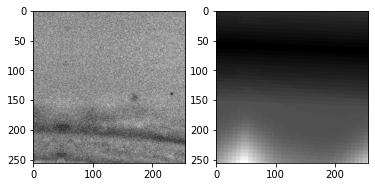

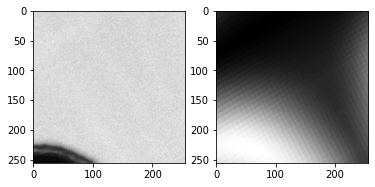

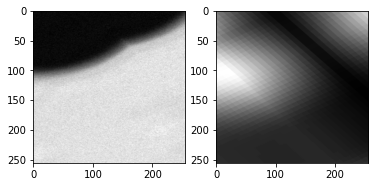

In [41]:
# sanity check in the generator size 0-31

for i in range(28,31):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0], cmap='gray')
    plt.show()

In [ ]:
# define model

import segmentation_models as sm

# sm.set_framework('tf.keras')  # ！ this serves for the sm.Unet
# sm.framework()

model = sm.Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])  # bce is differentiable
# print(model.summary())

In [ ]:
#Fit the model and train

import tensorflow.keras as k

callbacks = [
    #k.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir = './Unet/tensorBoard')
]

history = model.fit_generator(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=5, callbacks = callbacks)

2022-05-13 00:17:24.985039: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
/home/li52/.conda/envs/LM/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-05-13 00:17:24.985065: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2022-05-13 00:17:24.986765: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-05-13 00:17:25.954354: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-05-13 00:17:25.955110: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3000000000 Hz


Epoch 1/5
 1/50 [..............................] - ETA: 24:21 - loss: 1.5272 - iou_score: 0.1941

2022-05-13 00:17:55.968254: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2022-05-13 00:17:55.968302: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


 2/50 [>.............................] - ETA: 19:52 - loss: 1.5045 - iou_score: 0.1989

2022-05-13 00:18:20.705200: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2022-05-13 00:18:20.746141: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2022-05-13 00:18:20.759760: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./Unet/tensorBoard/train/plugins/profile/2022_05_13_00_18_20
2022-05-13 00:18:20.766040: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to ./Unet/tensorBoard/train/plugins/profile/2022_05_13_00_18_20/gv001.cluster.trace.json.gz
2022-05-13 00:18:20.775489: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: ./Unet/tensorBoard/train/plugins/profile/2022_05_13_00_18_20
2022-05-13 00:18:20.776098: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to ./Unet/tensorBoard/train/plugins/profile/2022_05_13_00_18_20/gv001.clus

 4/50 [=>............................] - ETA: 19:11 - loss: 1.4735 - iou_score: 0.2029

In [ ]:
# training visualization

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# iou
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
#Fit the model and train

import tensorflow.keras as k

callbacks = [
    #k.callbacks.EarlyStopping(patience=10, monitor='val_loss'),
    neptune_cbk,
    k.callbacks.TensorBoard(log_dir = './transfer/tensorBoard')
]

history = model.fit_generator(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=200, callbacks = callbacks)

# history = model.fit(my_generator, validation_data=validation_datagen, steps_per_epoch=50, validation_steps=50, epochs=50, callbacks = callbacks)  # change fit into fit generator in hemera

Epoch 1/200
50/50 [==============================] - 61s 1s/step - loss: 1.4156 - iou_score: 0.2858 - val_loss: 1.3969 - val_iou_score: 0.2991
Epoch 2/200
50/50 [==============================] - 49s 970ms/step - loss: 1.3964 - iou_score: 0.2988 - val_loss: 1.4060 - val_iou_score: 0.3007
Epoch 3/200
50/50 [==============================] - 49s 972ms/step - loss: 1.3963 - iou_score: 0.2995 - val_loss: 1.3965 - val_iou_score: 0.2998
Epoch 4/200
50/50 [==============================] - 48s 969ms/step - loss: 1.3964 - iou_score: 0.2993 - val_loss: 1.3965 - val_iou_score: 0.2999
Epoch 5/200
50/50 [==============================] - 49s 974ms/step - loss: 1.3962 - iou_score: 0.2995 - val_loss: 1.3967 - val_iou_score: 0.3017
Epoch 6/200
50/50 [==============================] - 48s 970ms/step - loss: 1.3962 - iou_score: 0.2995 - val_loss: 1.3977 - val_iou_score: 0.3025
Epoch 7/200
50/50 [==============================] - 49s 972ms/step - loss: 1.3962 - iou_score: 0.2997 - val_loss: 1.3972 - val

In [ ]:
# training visualization

#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# iou
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [ ]:
# using the 3rd stack of images

X_test = X_test1
Y_test = Y_test1

In [ ]:
# prediction IOU

#IOU
y_pred=model.predict(X_test)  # get test images
y_pred_thresholded = y_pred > 0.5

intersection = np.logical_and((Y_test > 0.5), y_pred_thresholded)  # calculate IOU requires binary
union = np.logical_or(Y_test, y_pred_thresholded)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU socre is: ", iou_score)

In [ ]:
# sanity check

test = y_pred[127,...]
test2 = Y_test[127,...]
print(test.shape)
plt.subplot(1,2,1)
plt.imshow(test,cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(test2,cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# test3 = (test*255).astype('uint8')
# plt.imshow(test3, cmap='gray')

In [ ]:
# visualization

test_img_number = random.randint(0, len(X_test)-1)
test_img = X_test[test_img_number]  # for test
test_img_input=np.expand_dims(test_img, 0)
ground_truth=Y_test[test_img_number]  # GT for the test
prediction = model.predict(test_img_input)  # prediction
prediction = prediction[0,:,:,0]

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()


In [ ]:
# save model as local

model.save("./transfer/model/Unet2D_transfer_resnet.h5")

In [ ]:
# save iamges as local
np.save("./transfer/IMG/transPred.npy", y_pred)
np.save("./transfer/IMG/transGT.npy", Y_test)


In [ ]:
# # resume to logging more data
# import neptune.new as neptune

# run = neptune.init(
#     project='leeleeroy/UNet-2D-EM',
#     api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI3YjVjOGVmZi04MjA4LTQ4N2QtOWIzYy05M2YyZWI1NzY3MmEifQ==",
#     run="UN-39",  
# )  # necessary credentials, the name could be used to reproduce the results 

# neptune.create_experiment(upload_source_files=['Unet_transfer.ipynb'])

In [ ]:
# neptune for showing the test images
# run = neptune.init(project="leeleeroy/UNet-2D-EM", run="UN-39")  # resume the documentation

for i in range(y_pred.shape[0]):
    predTemp = y_pred[i]
    predTemp = np.interp(predTemp, (predTemp.min(), predTemp.max()), (0, 1))  # neptune only receives 0-1
    GTTemp = Y_test[i]
    GTTemp = np.interp(GTTemp, (GTTemp.min(), GTTemp.max()), (0, 1))
    bar = np.zeros((y_pred[i].shape[0], 15))
    combTemp = np.concatenate((np.squeeze(predTemp),bar,np.squeeze(GTTemp)), axis=1)
    run["test/sample_images"].log(neptune.types.File.as_image(combTemp), name=str(i), description='test images from 3rd stack')  # upload the test results into neptune. could also add 'description'

In [ ]:
run.stop()  # remember to stop the neptune

#### check the generated data

In [11]:
GT_test = np.load("./transfer/IMG/transGT.npy")
pred_test = np.load("./transfer/IMG/transPred.npy")


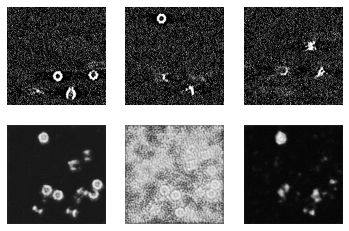

In [18]:
# sanity check


startNum = 37
n_samples = 3

for i in range(n_samples):
    plt.subplot(2, n_samples, 1+i)
    plt.axis('off')
    plt.imshow(GT_test[int(i+startNum)], cmap='gray')
    
for i in range(n_samples):
    plt.subplot(2, n_samples, 1+n_samples+i)
    plt.axis('off')
    plt.imshow(pred_test[int(i+startNum)], cmap='gray')
plt.show()